In [43]:
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark
import boto3

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).getOrCreate()
#spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).master("local[*]").getOrCreate()

import pandas as pd
import numpy as np
import re
import sys
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

batch_size = 126

In [44]:
#df_train = spark.read.format('parquet').load('s3a://fetch-data-puddle/spark/sandbox/mingjun/ORtrain/').sample(0.01)
#df_test = spark.read.format('parquet').load('s3a://fetch-data-puddle/spark/sandbox/mingjun/ORtest/')
def read_prefix_to_df(prefix):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('fetch-data-puddle')
    prefix_objs = bucket.objects.filter(Prefix=prefix)
    prefix_df = []
    for obj in prefix_objs:
        key = obj.key
        prefix_df.append(key)
        #body = obj.get()['Body'].read()
        #df = pd.DataFrame(body)
        #prefix_df.append(df)
    #return pd.concat(prefix_df)
    return prefix_df
#read_prefix_to_df('spark/sandbox/mingjun/ORtrainCSV')

In [45]:
def DowloandfileS3(inpt, out):
    bucketname = 'fetch-data-puddle' # replace with your bucket name
    s3 = boto3.resource('s3')
    s3.Bucket(bucketname).download_file(inpt, out)
path_train = read_prefix_to_df('spark/sandbox/mingjun/ORtrainCSV')[1]
print (path_train)
DowloandfileS3(path_train,'../train.csv')

path_test = read_prefix_to_df('spark/sandbox/mingjun/ORtestCSV')[1]
print (path_test)
DowloandfileS3(path_test,'../test.csv')

path_other = read_prefix_to_df('spark/sandbox/mingjun/ORotherCSV')[1]
print (path_other)
DowloandfileS3(path_other,'../other.csv')

spark/sandbox/mingjun/ORtrainCSV/part-00000-ace753b3-99a7-4b7d-9208-2db591cf18bd-c000.csv
spark/sandbox/mingjun/ORtestCSV/part-00000-4937e451-82b7-4161-986f-daf792106165-c000.csv
spark/sandbox/mingjun/ORotherCSV/part-00000-16c7370a-bcf8-43d3-b71f-722526f462c2-c000.csv


In [46]:
train = pd.read_csv('../train.csv', header=0)
print (train.shape)

test = pd.read_csv('../test.csv', header=0)
print (test.shape, test.columns)

other = pd.read_csv('../other.csv', header=0)
print (other.columns)

(60480, 2287)
(6781, 2287) Index(['user_id', 'offer_id', 'redeem_date', 'cat_brand_sums[0]',
       'cat_brand_sums[1]', 'cat_brand_sums[2]', 'cat_brand_sums[3]',
       'cat_brand_sums[4]', 'cat_brand_sums[5]', 'cat_brand_sums[6]',
       ...
       'id_catBrd_1081', 'id_catBrd_1082', 'id_catBrd_1083', 'id_catBrd_1084',
       'id_catBrd_1085', 'id_catBrd_1086', 'id_catBrd_1087', 'id_catBrd_1088',
       'id_catBrd_1089', 'target'],
      dtype='object', length=2287)
Index(['user_id', 'offer_id', 'redeem_date', 'facebook_authhot_[0]',
       'facebook_authhot_[1]', 'google_authhot_[0]', 'google_authhot_[1]',
       'statehot_[0]', 'statehot_[1]', 'statehot_[2]', 'statehot_[3]',
       'statehot_[4]', 'statehot_[5]', 'statehot_[6]', 'statehot_[7]',
       'statehot_[8]', 'statehot_[9]', 'statehot_[10]', 'statehot_[11]',
       'statehot_[12]', 'statehot_[13]', 'statehot_[14]', 'statehot_[15]',
       'statehot_[16]', 'statehot_[17]', 'statehot_[18]', 'statehot_[19]',
       'statehot_[

In [47]:
other_keep = ['user_id', 'offer_id', 'redeem_date','id_cat_recency',
'life',
'id_cat_tenure',
'id_recency',
'age',
'id_tenure',
'id_total_dollars',
'id_cat_points',
'total_offers',
'total_offer_units',
'total_cat_offer_units',
'total_cat_offers',
'total_offer_dollars',
'user_age',
'velocity',
]

other = other[other_keep]
display(other.head(5))

,user_id,offer_id,redeem_date,id_cat_recency,life,id_cat_tenure,id_recency,age,id_tenure,id_total_dollars,id_cat_points,total_offers,total_offer_units,total_cat_offer_units,total_cat_offers,total_offer_dollars,user_age,velocity
0,57d4d05ae4b0a807bde28019,5dd4305ba2e51b3e0e91d85d,2019-11-21,0,1,0,1,2,155,52.01,0.0,39,39,183338,156034,135.99,43,19.500000
1,59b372d7e4b08eb3b4028787,5dd439cb41cfc43b0e7a1407,2019-11-21,5,1,46,5,2,171,155.14,1050.0,302,302,183338,156034,842.29,43,151.000000
2,59c048a3e4b01ead606c78ae,5e128f5f56b90222fc2548b3,2020-02-05,73,28,75,9,29,75,57.70,15280.0,1711,1711,719585,580539,6457.15,42,59.000000
3,59d5648fe4b0bf935cf6e235,5d937813eca44d1154639bc8,2019-10-22,0,20,0,0,21,0,0.00,0.0,11483,11483,1034778,986513,40392.80,38,546.809524
4,59f72499e4b008f419dd15b8,5dc59366ace420773fa5d66c,2019-11-30,0,16,0,30,17,89,6.88,0.0,5632,6676,258842,210606,39788.76,57,331.294118


In [48]:
#x_train, x_test, y_train, y_test = train_test_split(train.drop(train.columns[]).values.astype(float), train[[u'target']].values, test_size=0.10, random_state=100)

train = pd.merge(other, train[['user_id', 'offer_id', 'redeem_date','target']], on=['user_id', 'offer_id', 'redeem_date'],how='right').fillna(0)
test =  pd.merge(other, test[['user_id', 'offer_id', 'redeem_date','target']], on=['user_id', 'offer_id', 'redeem_date'],how='right').fillna(0)
print (train.columns)
print (train.shape)
display(train.head(5))


Index(['user_id', 'offer_id', 'redeem_date', 'id_cat_recency', 'life',
       'id_cat_tenure', 'id_recency', 'age', 'id_tenure', 'id_total_dollars',
       'id_cat_points', 'total_offers', 'total_offer_units',
       'total_cat_offer_units', 'total_cat_offers', 'total_offer_dollars',
       'user_age', 'velocity', 'target'],
      dtype='object')
(60480, 19)


,user_id,offer_id,redeem_date,id_cat_recency,life,id_cat_tenure,id_recency,age,id_tenure,id_total_dollars,id_cat_points,total_offers,total_offer_units,total_cat_offer_units,total_cat_offers,total_offer_dollars,user_age,velocity,target
0,57d4d05ae4b0a807bde28019,5dd4305ba2e51b3e0e91d85d,2019-11-21,0,1,0,1,2,155,52.01,0.0,39,39,183338,156034,135.99,43,19.500000,0
1,59b372d7e4b08eb3b4028787,5dd439cb41cfc43b0e7a1407,2019-11-21,5,1,46,5,2,171,155.14,1050.0,302,302,183338,156034,842.29,43,151.000000,0
2,59c048a3e4b01ead606c78ae,5e128f5f56b90222fc2548b3,2020-02-05,73,28,75,9,29,75,57.70,15280.0,1711,1711,719585,580539,6457.15,42,59.000000,0
3,59d5648fe4b0bf935cf6e235,5d937813eca44d1154639bc8,2019-10-22,0,20,0,0,21,0,0.00,0.0,11483,11483,1034778,986513,40392.80,38,546.809524,0
4,59f72499e4b008f419dd15b8,5dc59366ace420773fa5d66c,2019-11-30,0,16,0,30,17,89,6.88,0.0,5632,6676,258842,210606,39788.76,57,331.294118,0


In [49]:
X_vars = list(train.columns[3:-1])
y_var = list(train.columns)[-1]
print (X_vars)
print (y_var)
x_train, x_test, y_train, y_test = train_test_split(train[X_vars].values, train[y_var].values, test_size=0.10, random_state=100)
print (x_train.shape)
print (y_train.shape)
n_columns = x_train.shape[1]
print (n_columns)

['id_cat_recency', 'life', 'id_cat_tenure', 'id_recency', 'age', 'id_tenure', 'id_total_dollars', 'id_cat_points', 'total_offers', 'total_offer_units', 'total_cat_offer_units', 'total_cat_offers', 'total_offer_dollars', 'user_age', 'velocity']
target
(54432, 15)
(54432,)
15


In [50]:
class ORDataset(Dataset):
    ## Define the underline data source
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])
        
dataset_train = ORDataset(x_train, y_train)

print ('Number of training set: ', len(dataset_train))
dataLoader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)

dataset_test = ORDataset(x_test, y_test)
print ('Number of test data set: ', len(dataset_test))
dataLoader_test = DataLoader(dataset_test, batch_size=len(y_test), shuffle=True, num_workers=1)

Number of training set:  54432
Number of test data set:  6048


In [51]:
if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
### Define the model components
class OfferRec(nn.Module):
    def __init__(self, input_size, layers=1):
        super(OfferRec, self).__init__()
       
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        ## x is the input tensor data

        out = self.linear(x.float())
        out = torch.sigmoid(out)

        return out

loss_fn = nn.MSELoss()
print (n_columns)
model = OfferRec(n_columns).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

15


epoch  10 loss:  37.68254290893674
epoch  20 loss:  37.68254425935447
epoch  30 loss:  37.68254804611206
epoch  40 loss:  37.682546282187104


Text(0, 0.5, 'MSE')

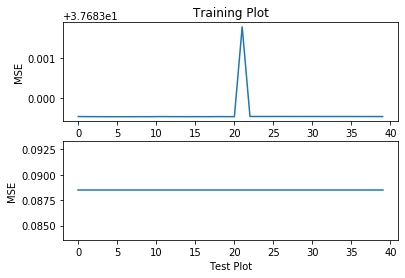

In [53]:
#list_users_train, list_items_train, list_labels_train, list_cats_train, list_manus_train,list_states_train

losses = []
losses_test = []

j= 0
for epoch in range(40):
    model.train()
    total_loss = 0
    for x, y in dataLoader_train:        
        x, y = x.to(device), y.to(device)
        model.zero_grad()

        pred_prob = model(x.float())
        loss = loss_fn(pred_prob, y.float().reshape(x.shape[0],1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    j=j+1
    if j % 10 == 0:
        print ('epoch ' , j, 'loss: ', total_loss)

    losses.append(total_loss)

    with torch.no_grad():
        model.eval()
        for x_t, y_t in dataLoader_test:
            x_t, y_t = x_t.to(device), y_t.to(device)
            pred_prob_test = model(x_t.float())
            loss_test = loss_fn(pred_prob_test, y_t.float().reshape(x_t.shape[0],1))
            loss_test = loss_test.item()
        losses_test.append(loss_test)

plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Training Plot')
plt.ylabel('MSE')

plt.subplot(2, 1, 2)
plt.plot(losses_test)
plt.xlabel('Test Plot')
plt.ylabel('MSE')

In [54]:
#Save ghe model
torch.save(model.state_dict(),'../mode_lr.tp')
the_model = OfferRec(n_columns)

In [55]:
print (test.columns)
print (test.values[:,3:-1].shape)
X_test_tensor = torch.from_numpy(test.values[:,3:-1].astype(float)).float()
y_test_tensor = torch.from_numpy(test['target'].values)

Index(['user_id', 'offer_id', 'redeem_date', 'id_cat_recency', 'life',
       'id_cat_tenure', 'id_recency', 'age', 'id_tenure', 'id_total_dollars',
       'id_cat_points', 'total_offers', 'total_offer_units',
       'total_cat_offer_units', 'total_cat_offers', 'total_offer_dollars',
       'user_age', 'velocity', 'target'],
      dtype='object')
(6781, 15)


In [56]:
with torch.no_grad():
    model = OfferRec(test.values[:,3:-1].shape[1])
    model.load_state_dict(torch.load('../mode_lr.tp'))
    model.eval()
    pred_prob = model(X_test_tensor)
    print (pred_prob.shape)
    pred = pd.DataFrame(torch.cat((pred_prob, y_test_tensor.float().reshape(-1,1)), 1).numpy(), columns = ['prob', 'target'])
display(pred.head(n=5))

torch.Size([6781, 1])


,prob,target
0,0.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


   rank   cnt      prob  target
0     0  6781  0.001475   522.0


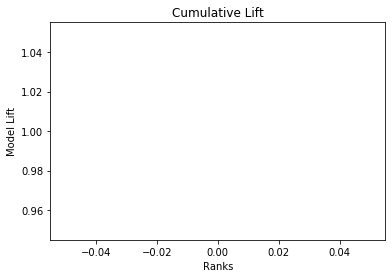

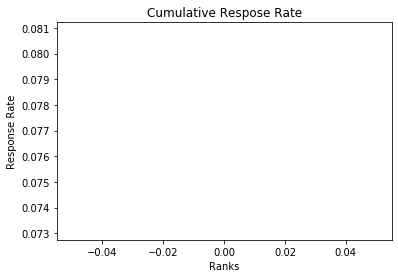

In [57]:
from imp import reload 
import Model
reload(Model)

Lift = Model.ModelLift(c=10)
lift = Lift.calLift(pred, target='target', prob='prob')
Model.Plot(lift)